<h1>BERTにおけるテキスト分類モデル

In [ ]:
! pip install transformers==4.5.0
!pip install fugashi unidic-lite
!pip install pytorch-lightning==1.2.7
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.7/212.7 kB 14.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 66.1 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tokenizers
Failed to build tokenizers
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (tokenizers)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 17.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... do

In [ ]:

from datasets import load_dataset
# Hugging Faceから直接ダウンロード
dataset = load_dataset("amazon_polarity")

# 最初の10000件だけを抽出する
train_subset = dataset["train"].select(range(1000))
test_subset = dataset["test"].select(range(1000))

In [ ]:
from transformers import AutoTokenizer

# モデルに合わせた最適なトークナイザを自動選択してくれる
#小文字化されたBERTの標準モデルに対応するトークナイザー
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# データセットをトークナイズ（バッチで）
def tokenize_function(example):
    #引数example["content"] ： レビュー本文のテキスト
    #tokenierによってテキストー＞トークンIDに変換している
    #引数Max_lengthを設定していないので、デフォルトで512個
    return tokenizer(example["content"], padding="max_length", truncation=True)

#map関数で、1件ずつtokenize_function関数を実行
#引数batched=True:複数件まとめて処理する
tokenized_train_datasets = train_subset.map(tokenize_function, batched=True)
tokenized_test_datasets = test_subset.map(tokenize_function, batched=True)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForSequenceClassification
#テキスト分類するためのBERTモデルをロードしている
#num_labels = 2とすることで、２クラス分類問題としている。
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import Trainer, TrainingArguments
#ファインチューニング　既存のモデルだけでは、特定のタスク（ネガティブポジション）には最適化されていないので、学習させる。
#もし、ファインチューニングをしないと精度が低くなる可能性がある。
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_datasets,
    eval_dataset=tokenized_test_datasets,
)

trainer.train()

Step,Training Loss


TrainOutput(global_step=125, training_loss=0.34518966674804685, metrics={'train_runtime': 99.9811, 'train_samples_per_second': 10.002, 'train_steps_per_second': 1.25, 'total_flos': 263111055360000.0, 'train_loss': 0.34518966674804685, 'epoch': 1.0})

In [ ]:
# 1. テストデータに対して予測
predictions = trainer.predict(tokenized_test_datasets)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# 2. ログからラベルを取り出す（確率が高い方）
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# 3. ポジティブ・ネガティブ件数を数える
print(f"ポジティブ判定件数: {np.sum(pred_labels == 1)}")
print(f"ネガティブ判定件数: {np.sum(pred_labels == 0)}")

ポジティブ判定件数: 439
ネガティブ判定件数: 561


In [ ]:
# ポジティブとネガティブなレビューリストをそれぞれ作成
positive_samples = []
negative_samples = []
for text, pred in zip(test_subset["content"], pred_labels):
    if pred == 1:  # ポジティブ
        positive_samples.append({"text": text, "score": pred})
    else:  # ネガティブ
        negative_samples.append({"text": text, "score": pred})

In [ ]:
import re
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def extract_and_visualize_frequent_words(dataset, pred_labels, target_label=1, top_n=30, title="WordCloud"):
    """
    指定ラベル(ポジティブorネガティブ)のレビューから頻出単語を抽出し、ワードクラウドを表示する

    Args:
        dataset: データセット（tokenized_test_datasetsなど）
        pred_labels: 予測ラベルのリスト
        target_label: 取り出したいラベル (1=ポジティブ, 0=ネガティブ)
        top_n: 上位何単語を表示するか
        title: ワードクラウドのタイトル
    """
    # 指定ラベルのインデックス取得
    target_indices = [i for i, label in enumerate(pred_labels) if label == target_label]

    # レビュー本文を集める
    target_reviews = [dataset[i]["content"] for i in target_indices]

    # 前処理＆単語リスト作成
    all_words = []
    for review in target_reviews:
        review = review.lower()
        review = re.sub(r"[^a-z\s]", "", review)
        words = review.split()
        words = [word for word in words if word not in ENGLISH_STOP_WORDS]
        all_words.extend(words)

    # 単語カウント
    word_counts = Counter(all_words)

    # 上位N単語だけ使う
    most_common_words = dict(word_counts.most_common(top_n))

    # WordCloudを作成
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(most_common_words)

    # プロット
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()


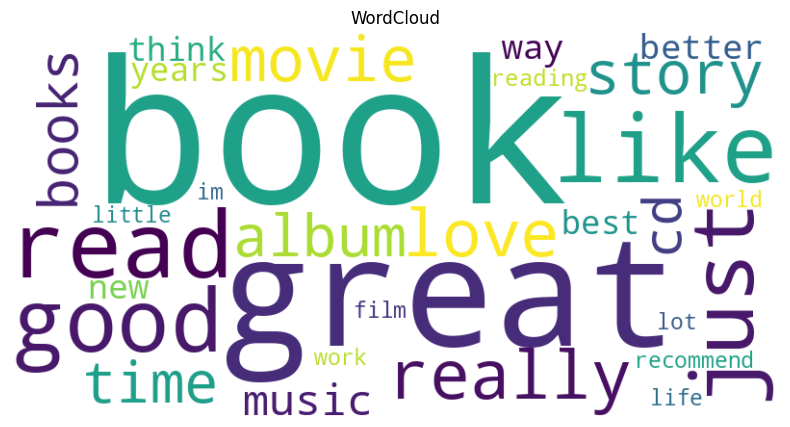

In [ ]:
positive_words = extract_and_visualize_frequent_words(tokenized_test_datasets, pred_labels, target_label=1)

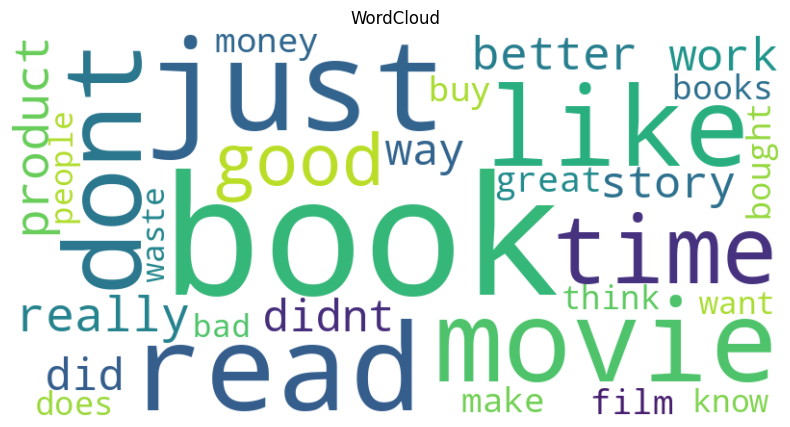

In [ ]:
negative_words = extract_and_visualize_frequent_words(tokenized_test_datasets, pred_labels, target_label=0)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


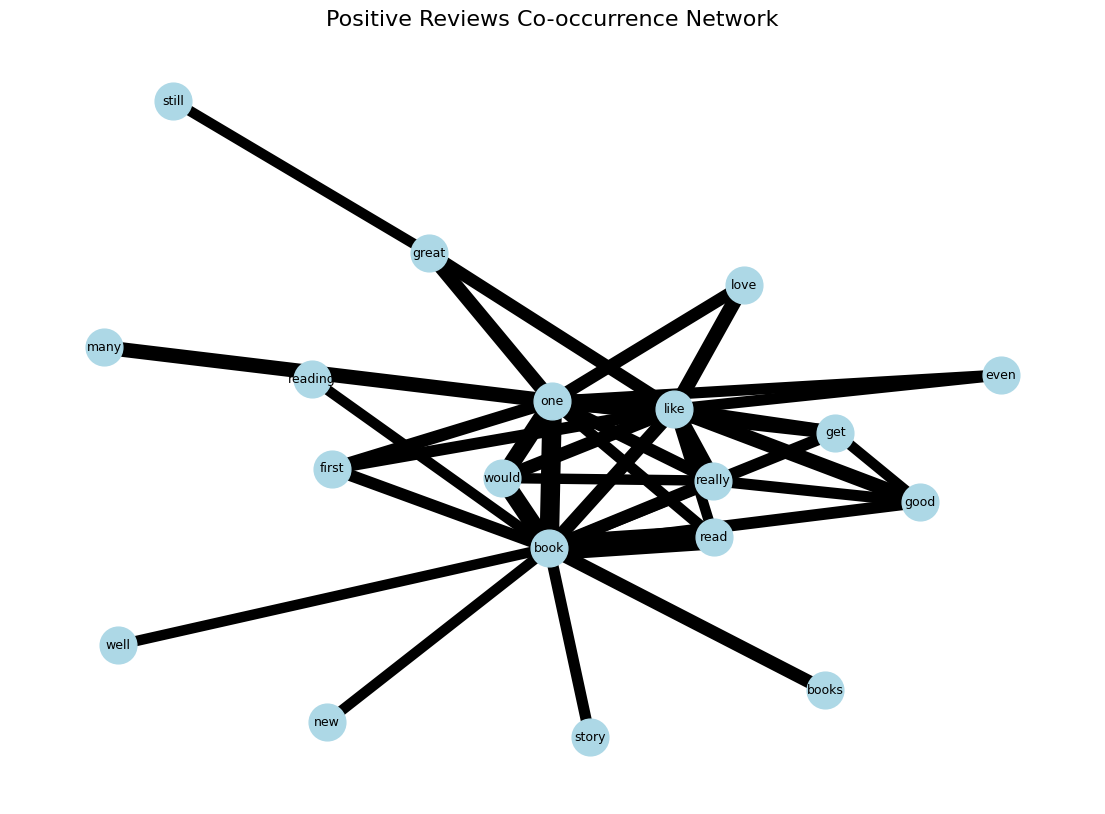

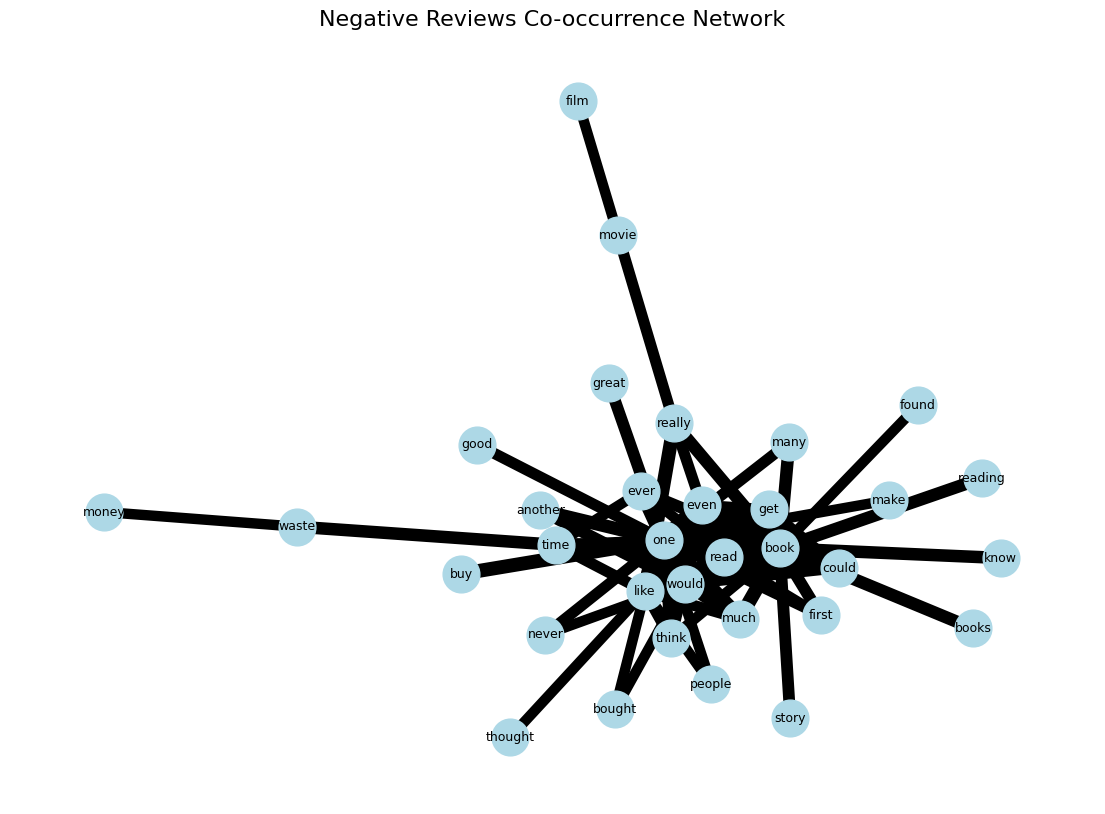

In [ ]:
import nltk
from nltk.corpus import stopwords
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import itertools

# 一度だけダウンロード
nltk.download('stopwords')

# ストップワードセット
stop_words = set(stopwords.words('english'))

def plot_cooccurrence_network(samples, title="Co-occurrence Network", min_freq=3):
    """
    サンプルリスト（テキストだけのリスト）から共起ネットワークを作成してプロットする関数

    Args:
        samples (list of str): ["テキスト1", "テキスト2", ...] 形式のリスト
        title (str): グラフのタイトル
        min_freq (int): 描画対象にする最小共起回数
    """

    all_words = []
    for text in samples:
        words = text.lower().split()
        filtered_words = [w for w in words if w.isalpha() and w not in stop_words]
        all_words.append(filtered_words)

    cooccurrence = Counter()
    for tokens in all_words:
        for pair in itertools.combinations(set(tokens), 2):
            cooccurrence[pair] += 1

    G = nx.Graph()
    for (w1, w2), freq in cooccurrence.items():
        if freq >= min_freq:
            G.add_edge(w1, w2, weight=freq)

    plt.figure(figsize=(14, 10))
    pos = nx.spring_layout(G, k=0.5, seed=42)
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=700)
    nx.draw_networkx_edges(G, pos, width=[d['weight']/2 for (_, _, d) in G.edges(data=True)])
    nx.draw_networkx_labels(G, pos, font_size=9)
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.show()

pos_texts = [sample["text"] for sample in positive_samples]
neg_texts = [sample["text"] for sample in negative_samples]

plot_cooccurrence_network(pos_texts, title="Positive Reviews Co-occurrence Network", min_freq=15)
plot_cooccurrence_network(neg_texts,  title="Negative Reviews Co-occurrence Network", min_freq=15)

In [ ]:
import seaborn as sns
def plot_review_length_distribution(texts):
    lengths = [len(text.split()) for text in texts]  # 単語数で計算
    plt.figure(figsize=(10, 6))
    sns.histplot(lengths, bins=30, kde=True)
    plt.title("the distributation of the length of sentence")
    plt.xlabel("the num of words")
    plt.ylabel("the num of reviews")
    plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12524 (\N{KATAKANA LETTER RE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12499 (\N{KATAKANA LETTER BI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12517 (\N{KATAKANA LETTER SMALL YU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print

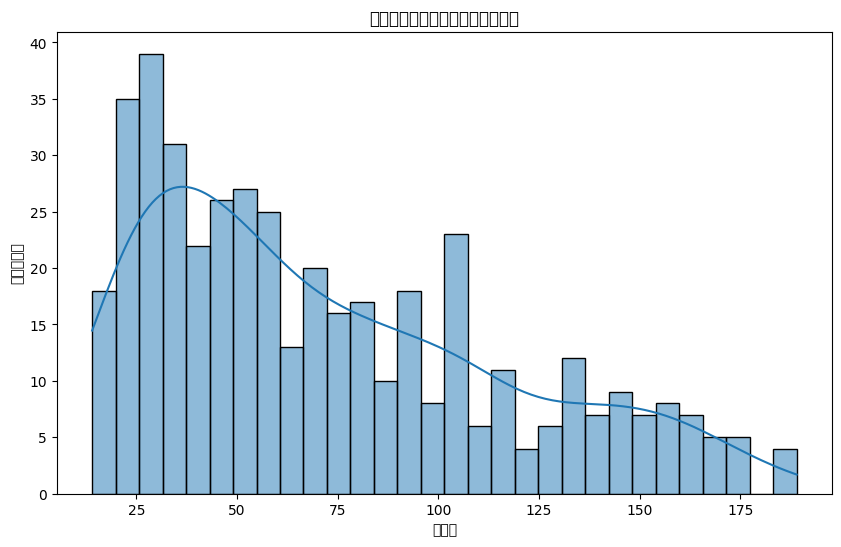

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12524 (\N{KATAKANA LETTER RE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12499 (\N{KATAKANA LETTER BI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12517 (\N{KATAKANA LETTER SMALL YU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print

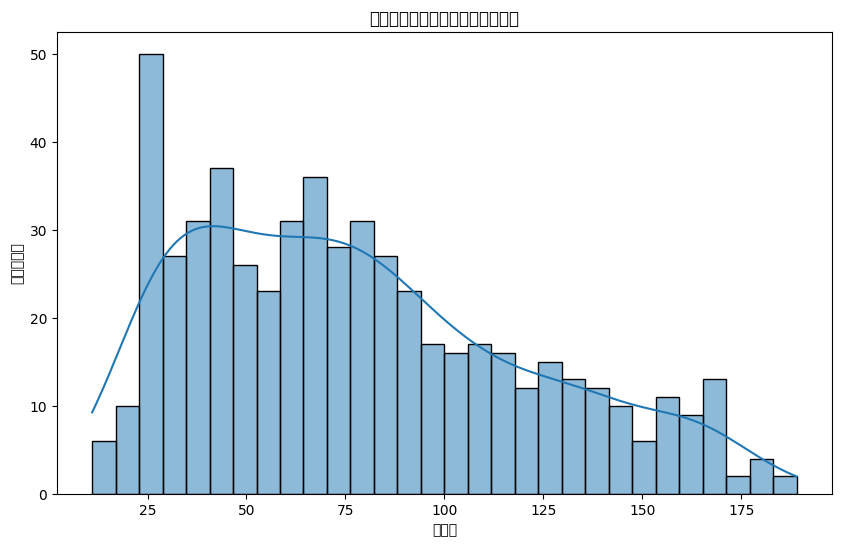

In [ ]:
# ポジティブレビュー
plot_review_length_distribution(pos_texts)

# ネガティブレビュー
plot_review_length_distribution(neg_texts)